In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import yt
import os
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs


ddir = os.path.join(yt.config.ytcfg.get('yt','test_data_dir'), 'sample_nc')
fi = os.path.join(ddir,'wUS-SH-2010_percent.nc')

def get_internal_IRIS():
    
    with xr.open_dataset(fi) as xr_ds:
        dvs = xr_ds.dvs.to_masked_array().data
        deprng = [xr_ds.depth.data.min(), xr_ds.depth.data.max()]
        lonrng=[xr_ds.longitude.data.min(), xr_ds.longitude.data.max()]
        latrng=[xr_ds.latitude.data.min(), xr_ds.latitude.data.max()]

    data = {'dvs': (dvs, "%")}
    
    bbox = np.array([
      deprng,   
      latrng,
      lonrng
    ])

    dims = ['depth', 'latitude', 'longitude']

    return yt.load_uniform_grid(data, data['dvs'][0].shape, 1.0, 
                                geometry=("internal_geographic", dims),
                                bbox=bbox)


ds = get_internal_IRIS() # load the dataset


yt : [INFO     ] 2021-05-13 17:08:19,885 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-05-13 17:08:19,886 Parameters: domain_dimensions         = [ 19  93 122]
yt : [INFO     ] 2021-05-13 17:08:19,886 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2021-05-13 17:08:19,887 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2021-05-13 17:08:19,887 Parameters: cosmological_simulation   = 0


In [2]:
# set our slice center
c = ds.domain_center
c[0] = 100 

# and a projection, with central longitude set to our domain center
proj_tuple =  ('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} )

# the extents of the large zoomed map
zoom_extents = (-117, -104, 32, 44)

Some helper functions

In [17]:
def get_slice():
    # returns a fixed-depth slice with the zlim, cmap we want
    p = yt.SlicePlot(ds, "depth", 'dvs',center=c)
    p.set_mpl_projection(proj_tuple)
    p.set_log('dvs',False)
    p.set_zlim('dvs',-8, 8)
    p.set_cmap('dvs','PuOr')
    return p

def add_features(carto_ax):
    # adds some shapefile data from NaturalEarth to an existing cartopy GeoAxes
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_1_states_provinces_lines', '10m',
            edgecolor='gray', facecolor='none'))
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_countries', '10m',
            edgecolor='black', facecolor='none'))
    
def add_zoombox_outline(carto_ax, zoom_extents, **plot_kwargs):
    # adds a box to a cartopy GeoAxes, for outlining the extents of the zoomed region
    xlocs = [zoom_extents[0], zoom_extents[1], zoom_extents[1], 
             zoom_extents[0], zoom_extents[0]]
    ylocs = [zoom_extents[2], zoom_extents[2], zoom_extents[3],
             zoom_extents[3], zoom_extents[2] ]
    carto_ax.plot(xlocs, ylocs, transform=ccrs.PlateCarree(), **plot_kwargs)

And now our plots

yt : [INFO     ] 2021-05-13 17:18:38,256 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 17:18:38,263 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 17:18:38,264 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 17:18:38,267 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 17:18:38,268 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 17:18:38,270 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 17:18:38,304 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -14.010000, Max = 8.820000.
yt : [WARNING  ] 2021-05-13 17:18:38,305 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later
yt : [INFO     ] 2021-05-13 17:18:47,990 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 17:18:47,991 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 17:18:47,991 ylim


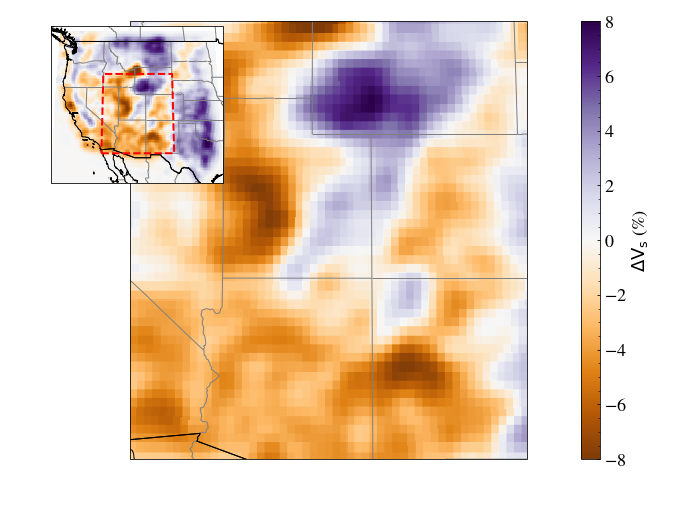

In [18]:
# initialize our slice plot to the zoomed-in view
p = get_slice()
p.set_colorbar_label('dvs',"$\Delta\mathrm{V_s}$ (%)")
p._setup_plots()
p.plots["dvs"].axes.set_extent(zoom_extents)
add_features(p.plots["dvs"].axes)
proj = p.plots["dvs"].axes.projection


# add a small child axis with the same projection
locator_box = [0.05, 0.65, 0.3, 0.3]
ax2 = p.plots["dvs"].figure.add_axes(locator_box, 
                                     projection=proj)

# get a new slice, covering the whole domain and adjust the axes and 
# figure references the child axis and existing figure
p2 = get_slice()
p2.plots["dvs"].axes = ax2
p2.plots["dvs"].figure = p.plots["dvs"].figure
p2.plots["dvs"].hide_colorbar()

# add our features 
p2._setup_plots()
add_features(ax2)
add_zoombox_outline(ax2, zoom_extents,color='r', linestyle='--', linewidth=2)

# the child axes position gets reset somewhere, so set it again here
ax2.set_position(locator_box) 

p